# Remembering The Past with Long Short-Term Memory (LSTM)

#### Loading Data

In [1]:
# Numerical Computing
import numpy as np
# Data Manipulation
import pandas as pd
# Data manipulation
import datetime
# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data Scalation
from sklearn.preprocessing import MinMaxScaler

# Deep Learning
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

# Warnings
import warnings

In [2]:
from tensorflow.keras.optimizers.legacy import Adam

In [3]:
warnings.filterwarnings('ignore')

##### Visualization Set Up

In [4]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = True

In [5]:
print(tf.__version__)

2.15.0


In [6]:
# Numerical & Tensorflow Setting Seeds
tf.random.set_seed(42)
np.random.seed(42)

#### Loading Data

In [7]:
train_df = pd.read_csv('/Users/isisromero/desktop/time_series/preprocessed/train.csv', index_col=0)
val_df = pd.read_csv('/Users/isisromero/desktop/time_series/preprocessed/val.csv', index_col=0)
test_df = pd.read_csv('/Users/isisromero/desktop/time_series/preprocessed/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


##### Setting Data Window Function

In [8]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

##### Setting Compile & Fit Function

In [9]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [10]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

### Long Short-Term Memory

#### LSTM as A Single-Step Model

In [11]:
# Single-SteP Window
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume']) 
# Wide Window
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

In [12]:
# Values obtained from chapter 14

mae_val = [0.083, 0.068, 0.033]
mae_test = [0.081, 0.068, 0.029]

In [13]:
# Stacking in Keras with LSTM

# Model Set-Up
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=1)
])

# Model Training
history = compile_and_fit(lstm_model, wide_window)

val_performance = {}
performance = {}

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0398 - mean_absolute_error: 0.1410 - val_loss: 0.0132 - val_mean_absolute_error: 0.0829
Epoch 2/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0089 - mean_absolute_error: 0.0671 - val_loss: 0.0061 - val_mean_absolute_error: 0.0559
Epoch 3/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0054 - mean_absolute_error: 0.0516 - val_loss: 0.0043 - val_mean_absolute_error: 0.0468
Epoch 4/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0044 - mean_absolute_error: 0.0458 - val_loss: 0.0038 - val_mean_absolute_error: 0.0436
Epoch 5/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0039 - mean_absolute_error: 0.0430 - val_loss: 0.0034 - val_mean_absolute_error: 0.0409
Epoch 6/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0036 - mean_absolute_error: 0.0411 - val_loss: 0.0031 - val_mean_absolute_error: 0.0389
Epoch 7/50
384/3

##### Single-Step Model Performance

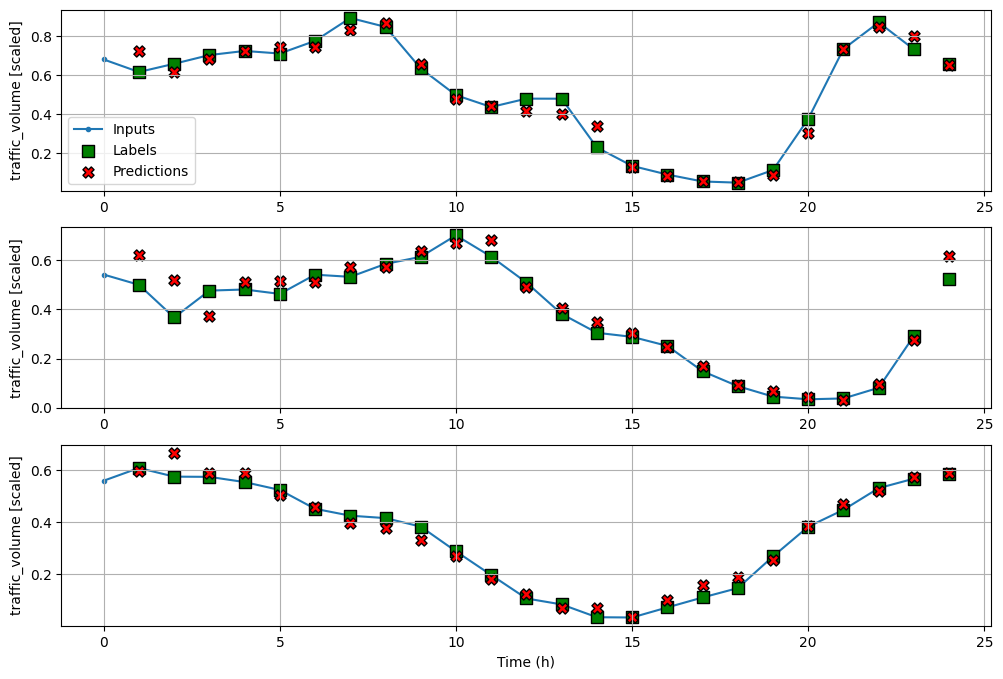

In [14]:
wide_window.plot(lstm_model)

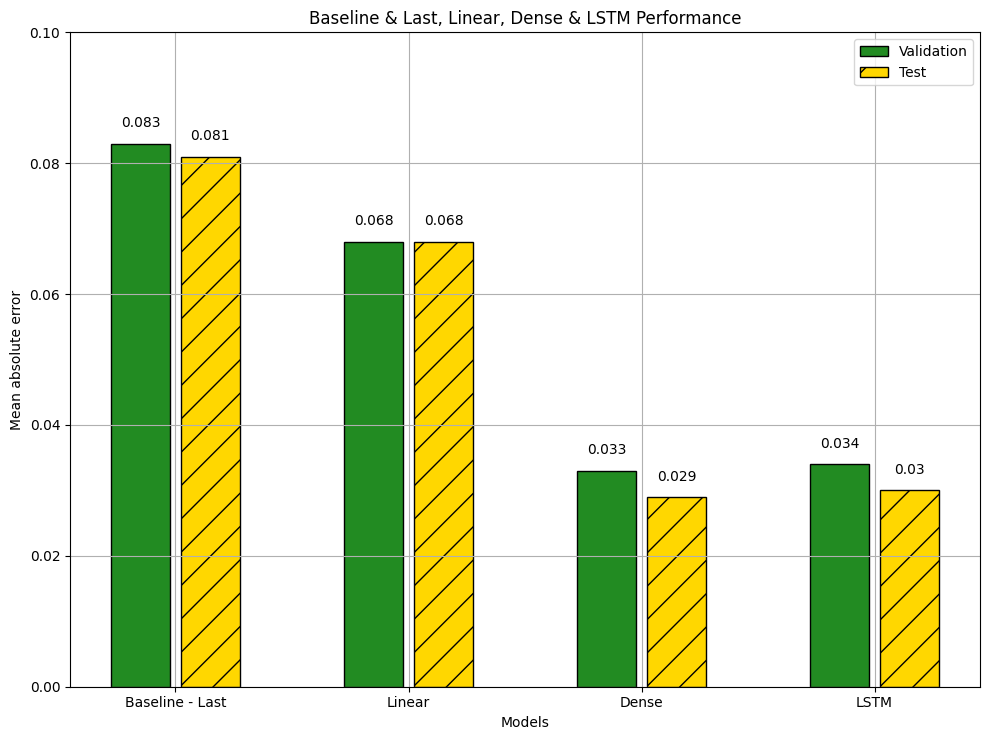

In [15]:
mae_val.append(val_performance['LSTM'][1])
mae_test.append(performance['LSTM'][1])

x = np.arange(4)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='forestgreen', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='gold', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.title('Baseline & Last, Linear, Dense & LSTM Performance')
plt.tight_layout()
plt.show()

#### LSTM as A Multi-Step Model

In [16]:
# Setting Multi-Step Window
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

In [17]:
# Values obtained from chapter 14

ms_mae_val = [0.352, 0.347, 0.088, 0.078]
ms_mae_test = [0.347, 0.341, 0.076, 0.064]

In [18]:
# Model Set-Up
ms_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

# Model Training
history = compile_and_fit(ms_lstm_model, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.val)
ms_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0465 - mean_absolute_error: 0.1557 - val_loss: 0.0206 - val_mean_absolute_error: 0.1003
Epoch 2/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0168 - mean_absolute_error: 0.0896 - val_loss: 0.0182 - val_mean_absolute_error: 0.0935
Epoch 3/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0151 - mean_absolute_error: 0.0828 - val_loss: 0.0165 - val_mean_absolute_error: 0.0842
Epoch 4/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0145 - mean_absolute_error: 0.0803 - val_loss: 0.0166 - val_mean_absolute_error: 0.0831
Epoch 5/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0141 - mean_absolute_error: 0.0789 - val_loss: 0.0164 - val_mean_absolute_error: 0.0878
Epoch 6/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0138 - mean_absolute_error: 0.0782 - val_loss: 0.0158 - val_mean_absolute_error: 0.0795
Epoch 7/50
383/3

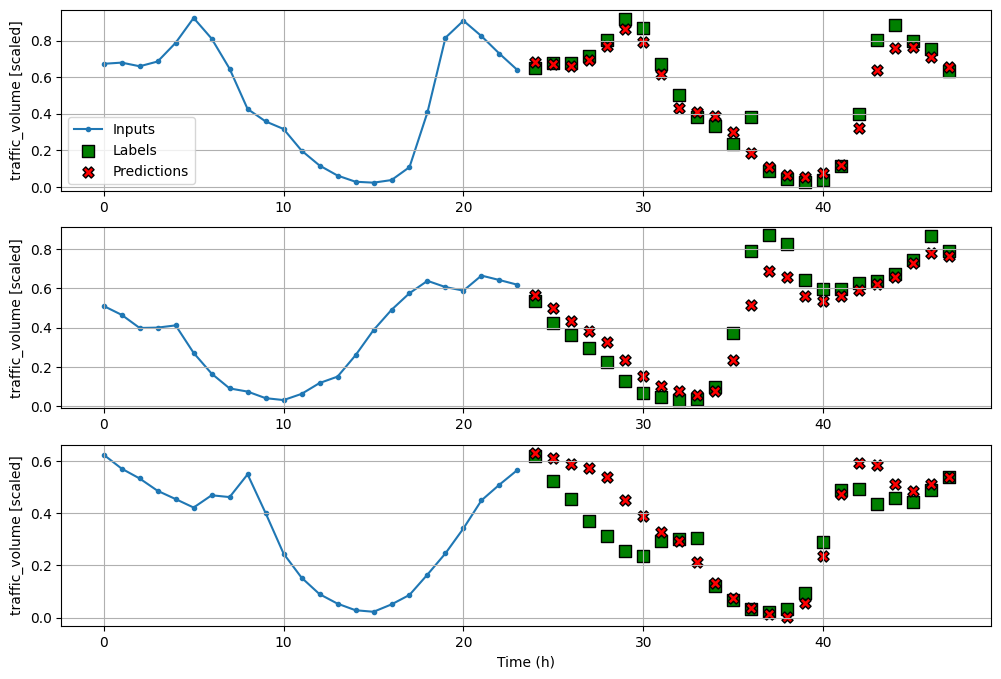

In [19]:
multi_window.plot(ms_lstm_model)

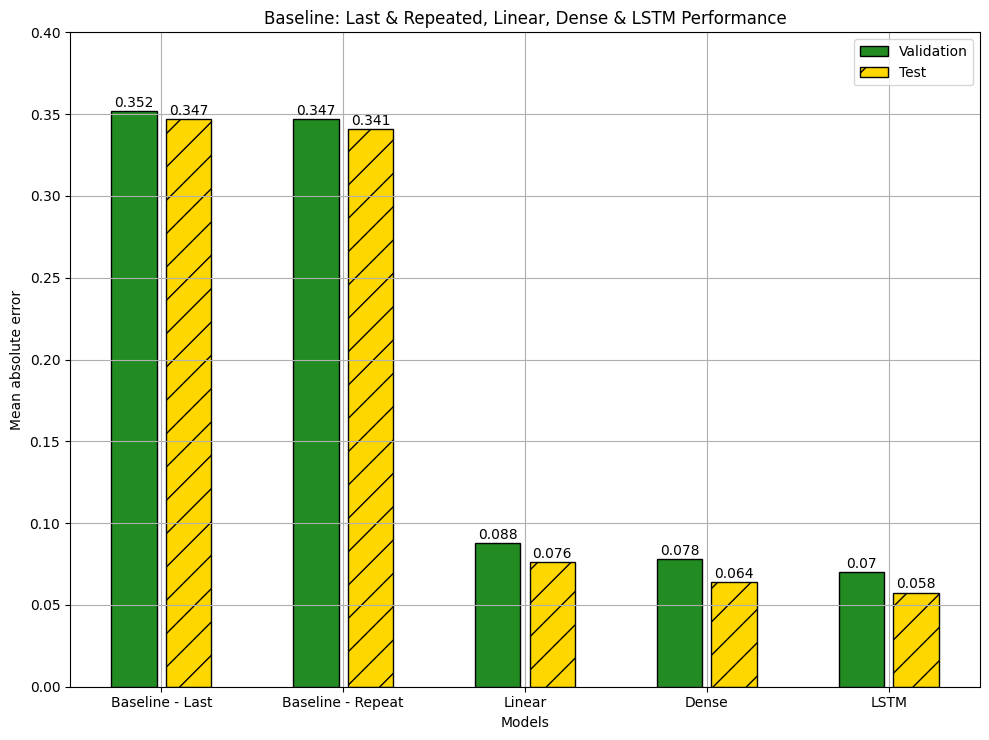

In [20]:
ms_mae_val.append(ms_val_performance['LSTM'][1])
ms_mae_test.append(ms_performance['LSTM'][1])

x = np.arange(5)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='forestgreen', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='gold', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.title('Baseline: Last & Repeated, Linear, Dense & LSTM Performance')
plt.tight_layout()
plt.show()

#### LSTM as A Mulir-Output Model

In [21]:
# Multi-Output Single Step
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume']) 
# Wide Window
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

In [22]:
# Values from chapter 14

mo_mae_val = [0.048, 0.039, 0.023]
mo_mae_test = [0.047, 0.036, 0.020]

In [25]:
# Model Set-Up
mo_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    # Temperature & Traffic Volume Targets
    Dense(units = 2)
])

# Model Training
history = compile_and_fit(mo_lstm_model, mo_wide_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.val)
mo_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 1s 3ms/step - loss: 0.0351 - mean_absolute_error: 0.1239 - val_loss: 0.0120 - val_mean_absolute_error: 0.0717
Epoch 2/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0075 - mean_absolute_error: 0.0568 - val_loss: 0.0052 - val_mean_absolute_error: 0.0471
Epoch 3/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0042 - mean_absolute_error: 0.0415 - val_loss: 0.0034 - val_mean_absolute_error: 0.0372
Epoch 4/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0032 - mean_absolute_error: 0.0360 - val_loss: 0.0027 - val_mean_absolute_error: 0.0334
Epoch 5/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0028 - mean_absolute_error: 0.0333 - val_loss: 0.0023 - val_mean_absolute_error: 0.0311
Epoch 6/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0026 - mean_absolute_error: 0.0314 - val_loss: 0.0022 - val_mean_absolute_error: 0.0305
Epoch 7/50
384/3

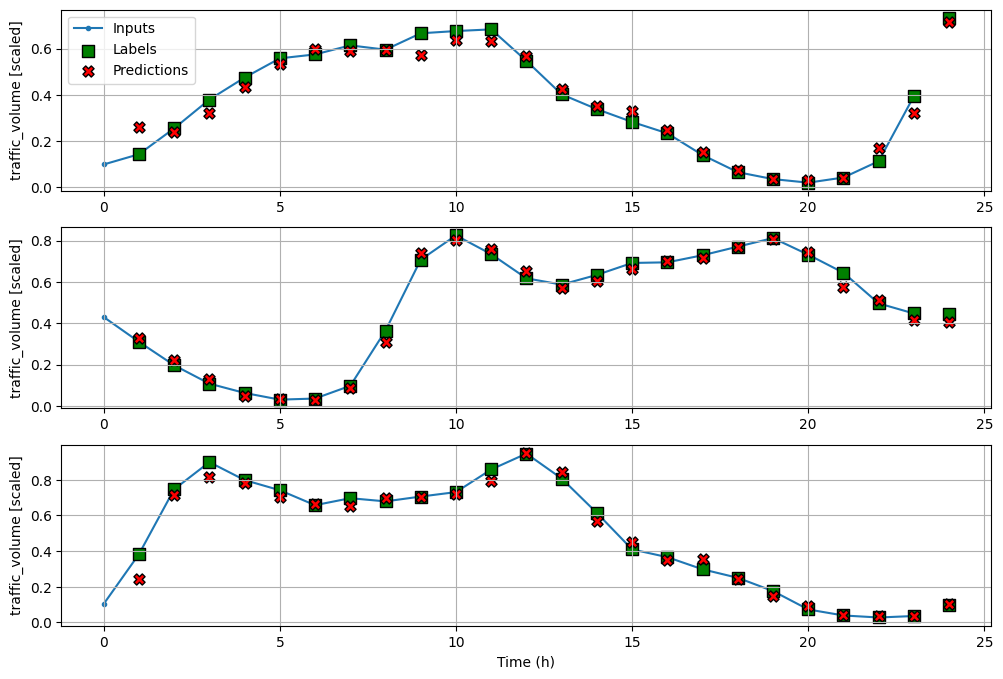

In [26]:
mo_wide_window.plot(mo_lstm_model)

#### Checking on Temperature Prediction Efficacy

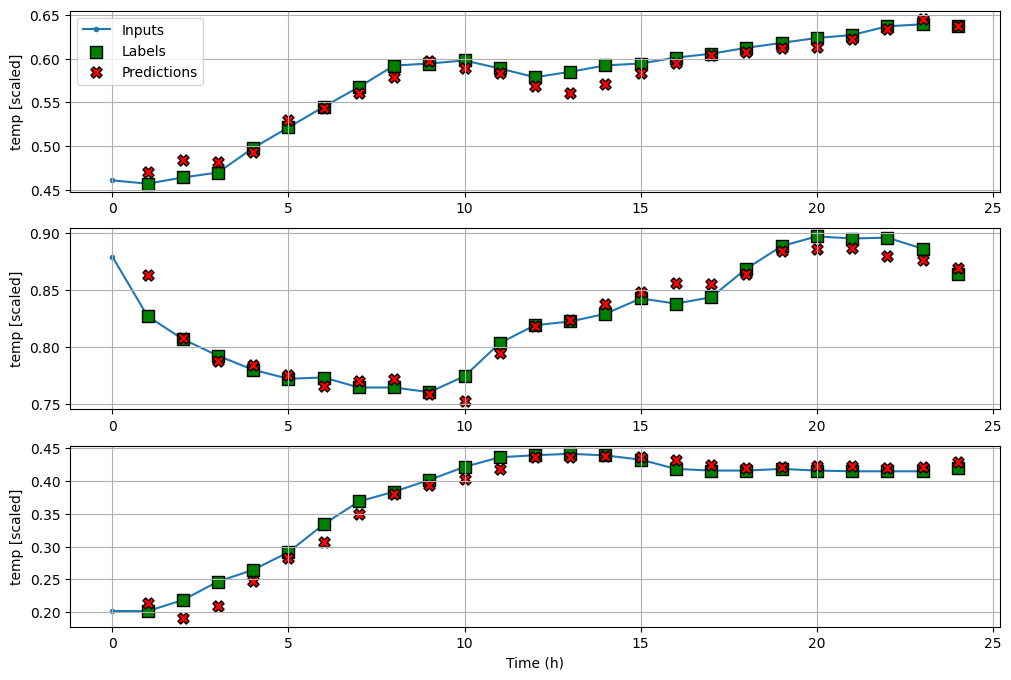

In [27]:
mo_wide_window.plot(model=mo_lstm_model, plot_col='temp')

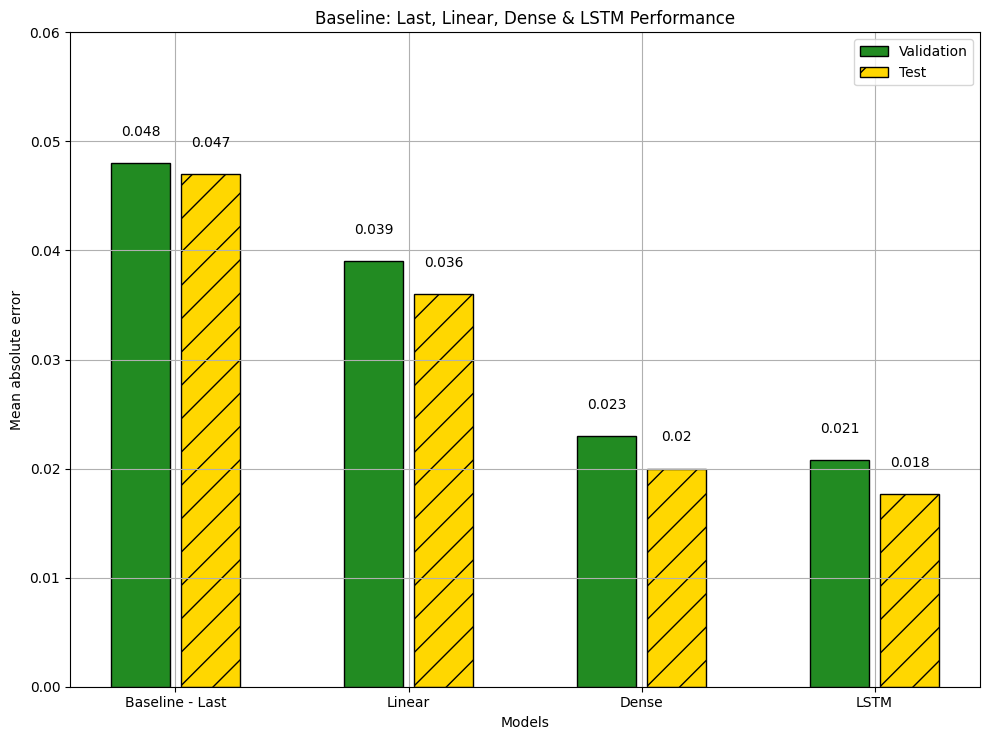

In [28]:
mo_mae_val.append(mo_val_performance['LSTM'][1])
mo_mae_test.append(mo_performance['LSTM'][1])

x = np.arange(4)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='forestgreen', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='gold', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.title('Baseline: Last, Linear, Dense & LSTM Performance')
plt.tight_layout()
plt.show()